In [1]:
#Imports
import logging
import os, random, time, sys
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
import ipdb
import keras
import pandas as pd

sys.path.append('../../../')
import feedforward_robust as ffr

sys.path.append('../../../utils/')
from utils.mnist_corruption import *
from utils.utils_models import *
from utils.utils_analysis import *
from utils.utils_feedforward import *

%load_ext autoreload
%autoreload 2

#Read the counter
ctr_file = "../../counter.txt"
f = open(ctr_file, 'r')
counter = f.readline()
f.close()

counter = 1 + int(counter)
f = open(ctr_file,'w')
f.write('{}'.format(counter))
f.close()
logfile = "../../logs/results_" + str(counter) + ".log"

logger = logging.getLogger("robustness")
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler(logfile)
fh.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(logging.StreamHandler())

Using TensorFlow backend.
W0716 17:03:48.101356 4573928896 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/cleverhans/utils_tf.py:341: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.



# Get Fashion MNIST Data

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train/255
x_test_ogi = x_test/255

In [4]:
#One hot the labels
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)                                                                                         
y_test = keras.utils.to_categorical(y_test, num_classes)

In [5]:
x_train_master_ogi, y_train_master = x_train[:30000], y_train[:30000]
x_train_slave, y_train_slave = x_train[30000:], y_train[30000:]

# Train Master

In [21]:
def train_nn_with_margins(margin):
    rem = 28 - margin
    x_train_master = x_train_master_ogi[:, :rem, :rem]
    x_test = x_test_ogi[:, :rem, :rem]
    #Flatten everything
    x_train_master_flat, input_shape = flatten_mnist(x_train_master) 
    x_train_slave_flat, _ = flatten_mnist(x_train_slave)
    x_test_flat, _  = flatten_mnist(x_test)
    
    #Configurations
    eps_train = 0.1                                                                                                                            
    eps_test = 0.07                                                                                                                            
    tensorboard_dir = "../tb/"                                                                                                                
    weights_dir = "../weights/"                                                                                                               
    load_weights = False                                                                                                              
    load_counter = 234                                                                                                            
    sigma = tf.nn.relu                                                                                                                         
    epochs, reg, lr = 3, 0.00, 1e-3    
    #epochs, reg, lr = 30, 0.00, 15e-4                                                                                                          
    pgd_eta, pgd_num_iter = 5000, 200

    tf.reset_default_graph()
    sess = tf.Session()
    hidden_sizes = [64, 64, 32]
    dataset = ((x_train_master_flat, y_train_master), (x_test_flat, y_test))

    scope_name = "teacher_student_fashion"
    if not load_weights:
        with tf.variable_scope(scope_name, reuse = False) as scope:

            logdir = tensorboard_dir + str(counter)

            #Create model
            writer = tf.summary.FileWriter(logdir)
            model = ffr.RobustMLP(input_shape, hidden_sizes, num_classes, writer = writer, scope = scope_name, logger = logger, sigma = sigma)
            sess.run(tf.global_variables_initializer())
            print("Created model successfully. Now going to train")

            #Train model
            model.fit(sess, x_train_master_flat, y_train_master, training_epochs = epochs, reg_op = reg , lr = lr)

            #Test model - regular, fgsm adv, pgd adv
            loss_reg, acc_reg = model.evaluate(sess, x_test_flat, y_test)
            print("----Regular test accuracy and loss ----")
            print((loss_reg, acc_reg))

            loss_fgsm, acc_fgsm, _ = model.adv_evaluate(sess, x_test_flat, y_test, eps_test, pgd = False)
            print("----FGSM test accuracy and loss ----")
            print((loss_fgsm, acc_fgsm))

            loss_pgd, acc_pgd, deltas = model.adv_evaluate(sess, x_test_flat, y_test, eps_test, pgd = True, eta=pgd_eta, num_iter = pgd_num_iter)
            print("----PGD test accuracy and loss ----")
            print((loss_pgd , acc_pgd))
        
        #Visualize original and perturbed images
        x_pgd = x_test_flat + deltas
        x_pgd_2d = x_pgd.reshape((10000, rem, rem))
        np.max(x_pgd_2d)
        
        plt.imshow(x_test[9], cmap = 'Greys')
        plt.savefig("/Users/adhyyan/Desktop/show_original_"+str(margin)+".pdf")
        plt.show()
        
        plt.imshow(x_pgd_2d[9], cmap = 'Greys')
        plt.savefig("/Users/adhyyan/Desktop/show_perturbed_"+str(margin)+".pdf")
        plt.show()


        
        return acc_reg, acc_fgsm, acc_pgd

Initialized instance variables of the robust model class
I0716 17:51:27.418515 4573928896 feedforward_robust.py:32] Initialized instance variables of the robust model class
Created placeholders for x and y
I0716 17:51:27.425514 4573928896 feedforward_robust.py:40] Created placeholders for x and y
Created layers and tensor for logits
I0716 17:51:27.506672 4573928896 feedforward_robust.py:44] Created layers and tensor for logits
Added accuracy computation to the graph
I0716 17:51:27.520753 4573928896 feedforward_robust.py:48] Added accuracy computation to the graph
Added cross-entropy loss computation to the graph
I0716 17:51:27.560069 4573928896 feedforward_robust.py:56] Added cross-entropy loss computation to the graph
Model graph was created
I0716 17:51:27.561989 4573928896 feedforward_robust.py:62] Model graph was created


Created model successfully. Now going to train


Epoch: 0001    cost: 0.635257396 
I0716 17:51:29.390347 4573928896 feedforward_robust.py:763] Epoch: 0001    cost: 0.635257396 
Accuracy on batch: 0.750000
I0716 17:51:29.391387 4573928896 feedforward_robust.py:764] Accuracy on batch: 0.750000
Epoch: 0002    cost: 0.445736641 
I0716 17:51:30.564867 4573928896 feedforward_robust.py:763] Epoch: 0002    cost: 0.445736641 
Accuracy on batch: 0.750000
I0716 17:51:30.565960 4573928896 feedforward_robust.py:764] Accuracy on batch: 0.750000
Epoch: 0003    cost: 0.403584572 
I0716 17:51:31.645310 4573928896 feedforward_robust.py:763] Epoch: 0003    cost: 0.403584572 
Accuracy on batch: 0.781250
I0716 17:51:31.646351 4573928896 feedforward_robust.py:764] Accuracy on batch: 0.781250
Optimization Finished!
I0716 17:51:31.647418 4573928896 feedforward_robust.py:765] Optimization Finished!
Final Train Loss 0.368981
I0716 17:51:31.827237 4573928896 feedforward_robust.py:773] Final Train Loss 0.368981
Final Train Accuracy 0.862900:
I0716 17:51:31.8284

----Regular test accuracy and loss ----
(0.44212544, 0.8403)


Model is being evaluated on FGSM data
I0716 17:51:32.137370 4573928896 feedforward_robust.py:682] Model is being evaluated on FGSM data
Model is being evaluated on PGD points generated using 5000.000000 learning rate and 200 iterations
I0716 17:51:32.225626 4573928896 feedforward_robust.py:684] Model is being evaluated on PGD points generated using 5000.000000 learning rate and 200 iterations


----FGSM test accuracy and loss ----
(2.514189, 0.2941)
iteration: 0
loss 1.153288
iteration: 20
loss 3.116591
iteration: 40
loss 3.216624
iteration: 60
loss 3.255602
iteration: 80
loss 3.275464
iteration: 100
loss 3.288668
iteration: 120
loss 3.297385
iteration: 140
loss 3.303655
iteration: 160
loss 3.307421
iteration: 180
loss 3.310277


This is to confirm that attack does not violate constraints
I0716 17:51:53.770544 4573928896 feedforward_robust.py:529] This is to confirm that attack does not violate constraints
Should be no more than eps
I0716 17:51:53.771749 4573928896 feedforward_robust.py:530] Should be no more than eps
0.07000002674027983
I0716 17:51:53.835427 4573928896 feedforward_robust.py:531] 0.07000002674027983


----PGD test accuracy and loss ----
(3.3131156, 0.2072)


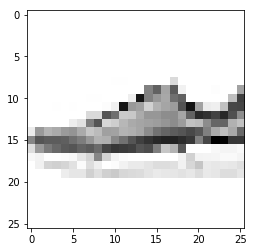

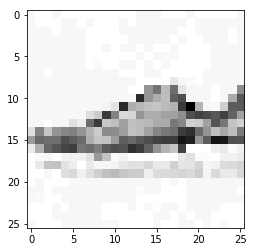

Initialized instance variables of the robust model class
I0716 17:51:54.640824 4573928896 feedforward_robust.py:32] Initialized instance variables of the robust model class
Created placeholders for x and y
I0716 17:51:54.688997 4573928896 feedforward_robust.py:40] Created placeholders for x and y
Created layers and tensor for logits
I0716 17:51:54.874300 4573928896 feedforward_robust.py:44] Created layers and tensor for logits
Added accuracy computation to the graph
I0716 17:51:54.887048 4573928896 feedforward_robust.py:48] Added accuracy computation to the graph
Added cross-entropy loss computation to the graph
I0716 17:51:54.932985 4573928896 feedforward_robust.py:56] Added cross-entropy loss computation to the graph
Model graph was created
I0716 17:51:54.934787 4573928896 feedforward_robust.py:62] Model graph was created


Created model successfully. Now going to train


Epoch: 0001    cost: 0.643111391 
I0716 17:51:57.649403 4573928896 feedforward_robust.py:763] Epoch: 0001    cost: 0.643111391 
Accuracy on batch: 0.781250
I0716 17:51:57.650693 4573928896 feedforward_robust.py:764] Accuracy on batch: 0.781250
Epoch: 0002    cost: 0.462811851 
I0716 17:51:59.024939 4573928896 feedforward_robust.py:763] Epoch: 0002    cost: 0.462811851 
Accuracy on batch: 0.781250
I0716 17:51:59.038703 4573928896 feedforward_robust.py:764] Accuracy on batch: 0.781250
Epoch: 0003    cost: 0.419056204 
I0716 17:52:00.309797 4573928896 feedforward_robust.py:763] Epoch: 0003    cost: 0.419056204 
Accuracy on batch: 0.750000
I0716 17:52:00.310863 4573928896 feedforward_robust.py:764] Accuracy on batch: 0.750000
Optimization Finished!
I0716 17:52:00.313524 4573928896 feedforward_robust.py:765] Optimization Finished!
Final Train Loss 0.377208
I0716 17:52:00.496952 4573928896 feedforward_robust.py:773] Final Train Loss 0.377208
Final Train Accuracy 0.862533:
I0716 17:52:00.4991

----Regular test accuracy and loss ----
(0.44274077, 0.8392)


Model is being evaluated on PGD points generated using 5000.000000 learning rate and 200 iterations
I0716 17:52:00.854336 4573928896 feedforward_robust.py:684] Model is being evaluated on PGD points generated using 5000.000000 learning rate and 200 iterations


----FGSM test accuracy and loss ----
(2.3030047, 0.2963)
iteration: 0
loss 1.124504
iteration: 20
loss 2.885541
iteration: 40
loss 2.957563
iteration: 60
loss 2.980816
iteration: 80
loss 2.993775
iteration: 100
loss 3.003947
iteration: 120
loss 3.008642
iteration: 140
loss 3.013168
iteration: 160
loss 3.015602
iteration: 180
loss 3.018285


This is to confirm that attack does not violate constraints
I0716 17:52:19.622778 4573928896 feedforward_robust.py:529] This is to confirm that attack does not violate constraints
Should be no more than eps
I0716 17:52:19.623928 4573928896 feedforward_robust.py:530] Should be no more than eps
0.07000002674027983
I0716 17:52:19.666176 4573928896 feedforward_robust.py:531] 0.07000002674027983


----PGD test accuracy and loss ----
(3.0187886, 0.215)


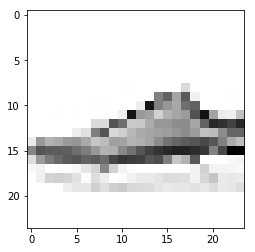

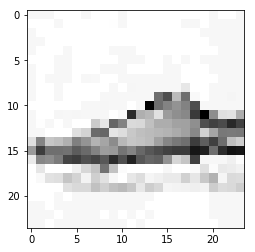

Initialized instance variables of the robust model class
I0716 17:52:20.289209 4573928896 feedforward_robust.py:32] Initialized instance variables of the robust model class
Created placeholders for x and y
I0716 17:52:20.297950 4573928896 feedforward_robust.py:40] Created placeholders for x and y
Created layers and tensor for logits
I0716 17:52:20.379981 4573928896 feedforward_robust.py:44] Created layers and tensor for logits
Added accuracy computation to the graph
I0716 17:52:20.398700 4573928896 feedforward_robust.py:48] Added accuracy computation to the graph
Added cross-entropy loss computation to the graph
I0716 17:52:20.426555 4573928896 feedforward_robust.py:56] Added cross-entropy loss computation to the graph
Model graph was created
I0716 17:52:20.427489 4573928896 feedforward_robust.py:62] Model graph was created


Created model successfully. Now going to train


Epoch: 0001    cost: 0.673562759 
I0716 17:52:22.010487 4573928896 feedforward_robust.py:763] Epoch: 0001    cost: 0.673562759 
Accuracy on batch: 0.750000
I0716 17:52:22.011623 4573928896 feedforward_robust.py:764] Accuracy on batch: 0.750000
Epoch: 0002    cost: 0.492051994 
I0716 17:52:22.970330 4573928896 feedforward_robust.py:763] Epoch: 0002    cost: 0.492051994 
Accuracy on batch: 0.781250
I0716 17:52:22.971735 4573928896 feedforward_robust.py:764] Accuracy on batch: 0.781250
Epoch: 0003    cost: 0.448711166 
I0716 17:52:23.862957 4573928896 feedforward_robust.py:763] Epoch: 0003    cost: 0.448711166 
Accuracy on batch: 0.781250
I0716 17:52:23.864012 4573928896 feedforward_robust.py:764] Accuracy on batch: 0.781250
Optimization Finished!
I0716 17:52:23.865484 4573928896 feedforward_robust.py:765] Optimization Finished!
Final Train Loss 0.442366
I0716 17:52:23.968703 4573928896 feedforward_robust.py:773] Final Train Loss 0.442366
Final Train Accuracy 0.834533:
I0716 17:52:23.9700

----Regular test accuracy and loss ----
(0.50877035, 0.8107)
----FGSM test accuracy and loss ----
(2.6131835, 0.2423)
iteration: 0
loss 1.374822
iteration: 20
loss 3.168836
iteration: 40
loss 3.227573
iteration: 60
loss 3.248439
iteration: 80
loss 3.258250
iteration: 100
loss 3.264579
iteration: 120
loss 3.269150
iteration: 140
loss 3.270713
iteration: 160
loss 3.273046
iteration: 180
loss 3.275783


This is to confirm that attack does not violate constraints
I0716 17:52:38.830538 4573928896 feedforward_robust.py:529] This is to confirm that attack does not violate constraints
Should be no more than eps
I0716 17:52:38.831610 4573928896 feedforward_robust.py:530] Should be no more than eps
0.07000002674027983
I0716 17:52:38.857082 4573928896 feedforward_robust.py:531] 0.07000002674027983


----PGD test accuracy and loss ----
(3.2763565, 0.1776)


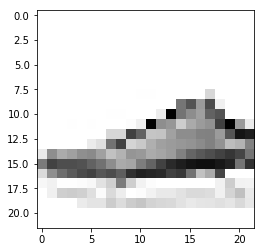

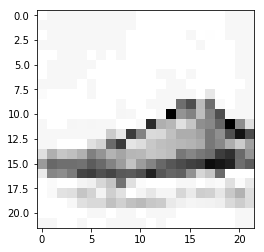

Initialized instance variables of the robust model class
I0716 17:52:39.381771 4573928896 feedforward_robust.py:32] Initialized instance variables of the robust model class
Created placeholders for x and y
I0716 17:52:39.389264 4573928896 feedforward_robust.py:40] Created placeholders for x and y
Created layers and tensor for logits
I0716 17:52:39.455663 4573928896 feedforward_robust.py:44] Created layers and tensor for logits
Added accuracy computation to the graph
I0716 17:52:39.467797 4573928896 feedforward_robust.py:48] Added accuracy computation to the graph
Added cross-entropy loss computation to the graph
I0716 17:52:39.498805 4573928896 feedforward_robust.py:56] Added cross-entropy loss computation to the graph
Model graph was created
I0716 17:52:39.500592 4573928896 feedforward_robust.py:62] Model graph was created


Created model successfully. Now going to train


Epoch: 0001    cost: 0.703124161 
I0716 17:52:41.021856 4573928896 feedforward_robust.py:763] Epoch: 0001    cost: 0.703124161 
Accuracy on batch: 0.718750
I0716 17:52:41.026310 4573928896 feedforward_robust.py:764] Accuracy on batch: 0.718750
Epoch: 0002    cost: 0.523086125 
I0716 17:52:41.900990 4573928896 feedforward_robust.py:763] Epoch: 0002    cost: 0.523086125 
Accuracy on batch: 0.718750
I0716 17:52:41.902235 4573928896 feedforward_robust.py:764] Accuracy on batch: 0.718750
Epoch: 0003    cost: 0.477229881 
I0716 17:52:42.722572 4573928896 feedforward_robust.py:763] Epoch: 0003    cost: 0.477229881 
Accuracy on batch: 0.781250
I0716 17:52:42.724272 4573928896 feedforward_robust.py:764] Accuracy on batch: 0.781250
Optimization Finished!
I0716 17:52:42.726746 4573928896 feedforward_robust.py:765] Optimization Finished!
Final Train Loss 0.447784
I0716 17:52:42.814170 4573928896 feedforward_robust.py:773] Final Train Loss 0.447784
Final Train Accuracy 0.832300:
I0716 17:52:42.8153

----Regular test accuracy and loss ----
(0.5113392, 0.8083)
----FGSM test accuracy and loss ----
(2.4633136, 0.2523)
iteration: 0
loss 1.409471
iteration: 20
loss 3.228952
iteration: 40
loss 3.283567
iteration: 60
loss 3.300682
iteration: 80
loss 3.312086
iteration: 100
loss 3.317996
iteration: 120
loss 3.322118
iteration: 140
loss 3.325328
iteration: 160
loss 3.329195
iteration: 180
loss 3.330654


This is to confirm that attack does not violate constraints
I0716 17:52:54.661578 4573928896 feedforward_robust.py:529] This is to confirm that attack does not violate constraints
Should be no more than eps
I0716 17:52:54.662683 4573928896 feedforward_robust.py:530] Should be no more than eps
0.07000002674027983
I0716 17:52:54.685777 4573928896 feedforward_robust.py:531] 0.07000002674027983


----PGD test accuracy and loss ----
(3.3316336, 0.1818)


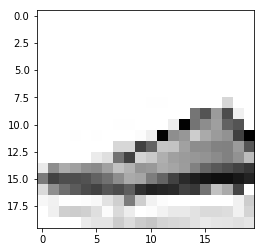

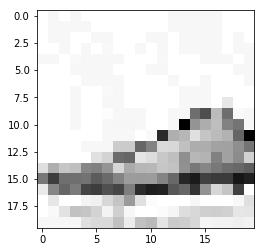

Initialized instance variables of the robust model class
I0716 17:52:55.180966 4573928896 feedforward_robust.py:32] Initialized instance variables of the robust model class
Created placeholders for x and y
I0716 17:52:55.188014 4573928896 feedforward_robust.py:40] Created placeholders for x and y
Created layers and tensor for logits
I0716 17:52:55.238512 4573928896 feedforward_robust.py:44] Created layers and tensor for logits
Added accuracy computation to the graph
I0716 17:52:55.246103 4573928896 feedforward_robust.py:48] Added accuracy computation to the graph
Added cross-entropy loss computation to the graph
I0716 17:52:55.279975 4573928896 feedforward_robust.py:56] Added cross-entropy loss computation to the graph
Model graph was created
I0716 17:52:55.281328 4573928896 feedforward_robust.py:62] Model graph was created


Created model successfully. Now going to train


Epoch: 0001    cost: 0.743678607 
I0716 17:52:56.784860 4573928896 feedforward_robust.py:763] Epoch: 0001    cost: 0.743678607 
Accuracy on batch: 0.687500
I0716 17:52:56.786118 4573928896 feedforward_robust.py:764] Accuracy on batch: 0.687500
Epoch: 0002    cost: 0.541772621 
I0716 17:52:57.649027 4573928896 feedforward_robust.py:763] Epoch: 0002    cost: 0.541772621 
Accuracy on batch: 0.750000
I0716 17:52:57.650094 4573928896 feedforward_robust.py:764] Accuracy on batch: 0.750000
Epoch: 0003    cost: 0.497605404 
I0716 17:52:58.516080 4573928896 feedforward_robust.py:763] Epoch: 0003    cost: 0.497605404 
Accuracy on batch: 0.750000
I0716 17:52:58.517077 4573928896 feedforward_robust.py:764] Accuracy on batch: 0.750000
Optimization Finished!
I0716 17:52:58.518101 4573928896 feedforward_robust.py:765] Optimization Finished!
Final Train Loss 0.469943
I0716 17:52:58.599409 4573928896 feedforward_robust.py:773] Final Train Loss 0.469943
Final Train Accuracy 0.825067:
I0716 17:52:58.6005

----Regular test accuracy and loss ----
(0.53020924, 0.8034)
----FGSM test accuracy and loss ----
(2.6031706, 0.2305)
iteration: 0
loss 1.522440
iteration: 20
loss 3.217798
iteration: 40
loss 3.258112
iteration: 60
loss 3.276235
iteration: 80
loss 3.284868
iteration: 100
loss 3.290010
iteration: 120
loss 3.293893
iteration: 140
loss 3.296404
iteration: 160
loss 3.298653
iteration: 180
loss 3.299528


This is to confirm that attack does not violate constraints
I0716 17:53:10.030194 4573928896 feedforward_robust.py:529] This is to confirm that attack does not violate constraints
Should be no more than eps
I0716 17:53:10.031286 4573928896 feedforward_robust.py:530] Should be no more than eps
0.07000002674027983
I0716 17:53:10.050383 4573928896 feedforward_robust.py:531] 0.07000002674027983


----PGD test accuracy and loss ----
(3.2992523, 0.1628)


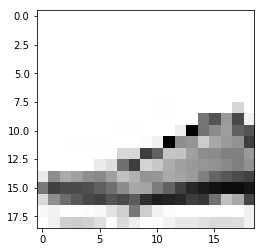

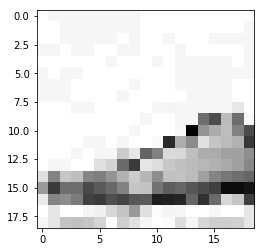

Initialized instance variables of the robust model class
I0716 17:53:10.577927 4573928896 feedforward_robust.py:32] Initialized instance variables of the robust model class
Created placeholders for x and y
I0716 17:53:10.587034 4573928896 feedforward_robust.py:40] Created placeholders for x and y
Created layers and tensor for logits
I0716 17:53:10.654020 4573928896 feedforward_robust.py:44] Created layers and tensor for logits
Added accuracy computation to the graph
I0716 17:53:10.661657 4573928896 feedforward_robust.py:48] Added accuracy computation to the graph
Added cross-entropy loss computation to the graph
I0716 17:53:10.686381 4573928896 feedforward_robust.py:56] Added cross-entropy loss computation to the graph
Model graph was created
I0716 17:53:10.687418 4573928896 feedforward_robust.py:62] Model graph was created


Created model successfully. Now going to train


Epoch: 0001    cost: 0.748920385 
I0716 17:53:12.323825 4573928896 feedforward_robust.py:763] Epoch: 0001    cost: 0.748920385 
Accuracy on batch: 0.687500
I0716 17:53:12.325417 4573928896 feedforward_robust.py:764] Accuracy on batch: 0.687500
Epoch: 0002    cost: 0.565422998 
I0716 17:53:13.388355 4573928896 feedforward_robust.py:763] Epoch: 0002    cost: 0.565422998 
Accuracy on batch: 0.718750
I0716 17:53:13.389412 4573928896 feedforward_robust.py:764] Accuracy on batch: 0.718750
Epoch: 0003    cost: 0.519247254 
I0716 17:53:14.174628 4573928896 feedforward_robust.py:763] Epoch: 0003    cost: 0.519247254 
Accuracy on batch: 0.718750
I0716 17:53:14.175639 4573928896 feedforward_robust.py:764] Accuracy on batch: 0.718750
Optimization Finished!
I0716 17:53:14.176684 4573928896 feedforward_robust.py:765] Optimization Finished!
Final Train Loss 0.481191
I0716 17:53:14.258095 4573928896 feedforward_robust.py:773] Final Train Loss 0.481191
Final Train Accuracy 0.821167:
I0716 17:53:14.2594

----Regular test accuracy and loss ----
(0.542425, 0.7981)
----FGSM test accuracy and loss ----
(2.4768727, 0.24)
iteration: 0
loss 1.490918
iteration: 20
loss 3.139304
iteration: 40
loss 3.158266
iteration: 60
loss 3.163408
iteration: 80
loss 3.165201
iteration: 100
loss 3.167782
iteration: 120
loss 3.168814
iteration: 140
loss 3.169233
iteration: 160
loss 3.171172
iteration: 180
loss 3.171388


This is to confirm that attack does not violate constraints
I0716 17:53:24.793892 4573928896 feedforward_robust.py:529] This is to confirm that attack does not violate constraints
Should be no more than eps
I0716 17:53:24.795514 4573928896 feedforward_robust.py:530] Should be no more than eps
0.07000002674027983
I0716 17:53:24.816115 4573928896 feedforward_robust.py:531] 0.07000002674027983


----PGD test accuracy and loss ----
(3.1713023, 0.174)


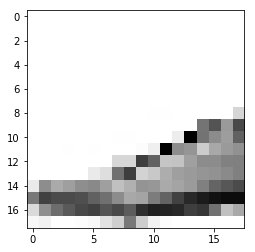

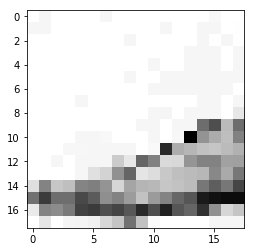

In [22]:
acc_reg_list = []
acc_fgsm_list = []
acc_pgd_list = []

for a in [2,4, 6, 8, 9, 10]:
    ar, af, ap = train_nn_with_margins(a)
    acc_reg_list.append(ar)
    acc_fgsm_list.append(af)
    acc_pgd_list.append(ap)

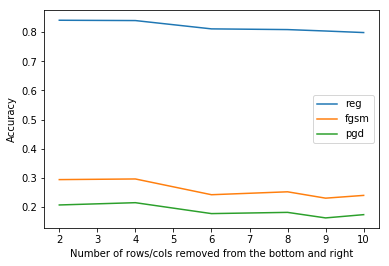

In [23]:
hor = np.array([2,4, 6, 8, 9, 10])
plt.plot(hor, acc_reg_list, label = 'reg')
plt.plot(hor, acc_fgsm_list, label = 'fgsm')
plt.plot(hor, acc_pgd_list, label = 'pgd')
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Number of rows/cols removed from the bottom and right")
plt.savefig("/Users/Adhyyan/Desktop/remove_margins_summary.pdf")

## Generate data for slave

In [ ]:
with tf.variable_scope(scope_name, reuse = False) as scope:
        loss_reg, acc_reg = model.evaluate(sess, x_test_flat, y_test)
        print("----Regular test accuracy and loss ----")
        print((loss_reg, acc_reg))
        
        z_train_slave = model.get_prediction(sess, x_train_slave_flat)
        z_test_slave = model.get_prediction(sess, x_test_flat)

In [ ]:
z_train_slave[0]

# Train slave

In [ ]:
#Setup - Dataset stuff
def slave_training():
    epochs = 20
    lr = 15e-4
    tf.reset_default_graph()
    sess = tf.Session()
    hidden_sizes = [64, 64, 32]
    dataset = ((x_train_slave_flat, z_train_slave), (x_test_flat, y_test))

    scope_name = "teacher_student_fashion"
    if not load_weights:
        with tf.variable_scope(scope_name, reuse = tf.AUTO_REUSE) as scope:

            logdir = tensorboard_dir + str(counter)

            #Create model
            writer = tf.summary.FileWriter(logdir)
            model = ffr.RobustMLP(input_shape, hidden_sizes, num_classes, writer = writer, scope = scope_name, logger = logger, sigma = sigma, classification = False)
            sess.run(tf.global_variables_initializer())
            print("Created model successfully. Now going to train")

            #Train model
            model.fit(sess, x_train_slave_flat, z_train_slave, training_epochs = epochs, reg_op = reg , lr = lr)

            """
            #Save weights
            weights = tf.trainable_variables()
            #weights = model.get_weights()[0] + model.get_weights()[1]
            saver = tf.train.Saver(weights)
            weights_path = saver.save(sess, weights_dir + "model_" + str(counter) + ".ckpt")
            print("Saved model at %s"%weights_path)
            """
            loss_real_train, acc_train = model.evaluate(sess, x_train_slave_flat, z_train_slave)

            #Test model - regular, fgsm adv, pgd adv
                        
            loss_class_reg, acc_reg = model.evaluate(sess, x_test_flat, y_test)
            print("----Regular test loss and accuracy ----")
            print((loss_class_reg, acc_reg))
            
            loss_real_reg, acc_real_reg = model.evaluate(sess, x_test_flat, z_test_slave)
            print("----Real test loss and accuracy comparing to teacher ----")
            print((loss_real_reg, acc_real_reg))

            loss_fgsm, acc_fgsm = model.adv_evaluate(sess, x_test_flat, y_test, eps_test, pgd = False)
            print("----FGSM test loss and accuracy ----")
            print((loss_fgsm, acc_fgsm))

            loss_pgd, acc_pgd = model.adv_evaluate(sess, x_test_flat, y_test, eps_test, pgd = True, eta=pgd_eta, num_iter = pgd_num_iter)
            print("----PGD test loss and accuracy ----")
            print((loss_pgd , acc_pgd))
            
            slave_train_confidences = model.get_prediction(sess, x_train_slave_flat)
            slave_test_confidences = model.get_prediction(sess, x_test_flat)
            
            return loss_real_train, acc_train, loss_real_reg, acc_real_reg, acc_reg, slave_train_confidences, slave_test_confidences
        
        

In [ ]:
tup = slave_training()

In [ ]:
a

In [ ]:
list(tup)

In [ ]:
df = pd.DataFrame()
df['mse on z_train'] = []
df['acc on z_train'] = []
df['mse on z_test'] = []
df['acc on z_test'] = []
df['acc on y_test'] = []

In [ ]:
train_confidences = []
test_confidences = []
for i in range(3):
    loss_real_train, acc_train, loss_real_reg, acc_real_reg, acc_reg, slave_train_confidences, slave_test_confidences = slave_training()
    df.loc[i] = [loss_real_train, acc_train, loss_real_reg, acc_real_reg, acc_reg]
    train_confidences.append(slave_train_confidences)
    test_confidences.append(slave_test_confidences)

In [ ]:
df

In [ ]:
#df.to_excel("ts_fashion_results.xlsx")  